<a href="https://colab.research.google.com/github/sapto-nugroho/PCD/blob/main/PCD_Assignment01/PCD_Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#
##Nama  : Sapto Nugroho
##NIU   : 565712

###git clone

In [1]:
!ls
!git clone https://github.com/sapto-nugroho/PCD.git
!ls

sample_data
Cloning into 'PCD'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 188 (delta 63), reused 42 (delta 9), pack-reused 0 (from 0)
Receiving objects: 100% (188/188), 5.40 MiB | 9.41 MiB/s, done.
Resolving deltas: 100% (63/63), done.
PCD  sample_data


##function================================================================================================================

###Import

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import statistics as st
import pdb
from scipy.interpolate import CubicSpline


In [ ]:
f = np.arange(0,4,0.5)
# print(f)

plt.plot(f,np.ones(len(f)),'o')
# plt.plot(f,np.linspace(0,1,10),'o')
plt.plot(xs, ys_RGB[0][3], 'o', label='data points')
plt.plot(temp_xs[0,3], temp_ys[0,3], label='cubic spline interpolation')
plt.show()

###Image Acquisition

In [4]:
def Acquire(src,size):
  #Image and Copy
  img = plt.imread(src)
  img_copy = img.copy()

  #Plot Image dan Copy
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img)
  axs[0].set_title(f"Original, shape, {img.shape}")
  axs[1].imshow(img_copy)
  axs[1].set_title(f"Copy, shape {img_copy.shape}")
  plt.tight_layout()
  plt.show()

  return img, img_copy


###Downsampling

In [7]:
def DownSample(img_copy,order,size):
  div = 2**order

  #baris
  baris = img_copy.shape[0]//div
  print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

  #kolom
  kolom = img_copy.shape[1]//div
  print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

  #Matriks Image DownSample (img_ds)
  img_ds = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  print(img_copy.shape,"==>",img_ds.shape)
  #print(img_ds)

  #DownSampling
  for j in range(0,img_ds.shape[0]):
    # print("J= ",j,j*div)
    for i in range(0,img_ds.shape[1]):
      # print(i, i*div)
      img_ds[j][i] = img_copy[j*div][i*div]

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_ds)
  axs[1].set_title(f"After, shape {img_ds.shape}")
  fig.suptitle("Downsampling", fontsize=16)
  plt.tight_layout()
  plt.show()

  return img_ds


###Decimation

In [8]:
#new Decimate
def Decimate(mode,img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)
  baris_lama, kolom_lama, c = img_copy.shape

  #Matriks Image Decimation (img_dc)
  img_dc = np.zeros(shape=(baris_baru,kolom_baru,3),dtype=int)

  k_baris = (baris_lama - 1)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama - 1)/(kolom_baru) if kolom_baru != 0 else 0

  match mode:
    case 'MAX':
      mode = "Max"
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,:] = img_copy[x1, y1,:]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[x1,k,0])
              img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[x1,k,1])
              img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[x1,k,2])

          elif (y2 == y1):
            for k in range(x1,x2+1):
              img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[k,y1,0])
              img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[k,y1,1])
              img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[k,y1,2])

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                img_dc[i,j,0] = max(img_dc[i,j,0],img_copy[k, l,0])
                img_dc[i,j,1] = max(img_dc[i,j,1],img_copy[k, l,1])
                img_dc[i,j,2] = max(img_dc[i,j,2],img_copy[k, l,2])

    case 'MEDIAN':
      mode = "Median"
      temp = [[],[],[]]
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,0] = img_copy[x1, y1,0]
            img_dc[i,j,1] = img_copy[x1, y1,1]
            img_dc[i,j,2] = img_copy[x1, y1,2]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              temp[0].append(img_copy[x1,k,0])
              temp[1].append(img_copy[x1,k,1])
              temp[2].append(img_copy[x1,k,2])

          elif (y2 == y1):
            for k in range(x1,x2+1):
              temp[0].append(img_copy[k,y1,0])
              temp[1].append(img_copy[k,y1,1])
              temp[2].append(img_copy[k,y1,2])

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                temp[0].append(img_copy[k,l,0])
                temp[1].append(img_copy[k,l,1])
                temp[2].append(img_copy[k,l,2])

          img_dc[i,j,0] = st.median(temp[0])
          img_dc[i,j,1] = st.median(temp[1])
          img_dc[i,j,2] = st.median(temp[2])
          temp = [[],[],[]]

    case 'MEAN':
      mode = "Mean"
      for i in range(baris_baru):
        for j in range(kolom_baru):

          x1 = math.ceil(i*k_baris)
          x2 = math.floor((i+1)*k_baris)
          y1 = math.ceil(j*k_kolom)
          y2 = math.floor((j+1)*k_kolom)
          dx = x2-x1+1
          dy = y2-y1+1
          # pdb.set_trace()

          q = np.array([0,0,0])
          if (x2 == x1) and (y2 == y1):
            img_dc[i,j,0] = img_copy[x1, y1,0]
            img_dc[i,j,1] = img_copy[x1, y1,1]
            img_dc[i,j,2] = img_copy[x1, y1,2]

          elif (x2 == x1):
            for k in range(y1,y2+1):
              img_dc[i,j,:] += img_copy[x1, k,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))

          elif (y2 == y1):
            for k in range(x1,x2+1):
              img_dc[i,j,:] += img_copy[k, y1,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))

          else:
            for k in range(x1,x2+1):
              for l in range(y1,y2+1):
                img_dc[i,j,:] += img_copy[k, l,:]
            img_dc[i,j,:] = np.round(img_dc[i,j,:]/(dx*dy))
            # pdb.set_trace()

          # img_dc[i,j,:] = q1

  img_dc = img_dc.astype(np.uint8)

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_dc)
  axs[1].set_title(f"After, shape {img_dc.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_dc


###Upsampling

####Nearest Neighbor

In [ ]:
def up_NN(img_copy,baris_baru,kolom_baru,size):
  img_copy = img_copy.astype(int)

  baris_lama, kolom_lama, c = img_copy.shape
  # print(baris_lama,kolom_lama,c)

  # baris_baru = baris_lama*order
  # kolom_baru = kolom_lama*order

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c))

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

  for i in range(baris_baru):
    for j in range(kolom_baru):

      #pemetaan koordinat baru ke lama (koordinat lama = koordinat baru * skala)
      x = i*k_baris
      y = j*k_kolom

      #4-Neighborhood dari (x,y)
      x1 = math.floor(x)
      x2 = min(baris_lama - 1, math.ceil(x))
      y1 = math.floor(y)
      y2 = min(kolom_lama - 1, math.ceil(y))

      if (x2 == x1) and (y2 == y1):
        q = img_copy[int(x), int(y), :]
      elif (x2 == x1):
        for k in range(c):
          q[k] = min(img_copy[int(x), int(y1), k],img_copy[int(x), int(y2), k])
      elif (y2 == y1):

        for k in range(c):
          q[k] = min(img_copy[int(x1), int(y), k],img_copy[int(x2), int(y), k])
      else:
        v1 = img_copy[x1, y1, :]
        v2 = img_copy[x2, y1, :]
        v3 = img_copy[x1, y2, :]
        v4 = img_copy[x2, y2, :]
        for k in range(c):
          q[k] = min(v1[k],v2[k],v3[k],v4[k])

      img_us[i,j,:] = q

  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

####Bilinear

In [ ]:
def up_Bilinear(img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)

  baris_lama, kolom_lama, c = img_copy.shape
  # print(baris_lama,kolom_lama,c)

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c))

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

  for i in range(baris_baru):
    for j in range(kolom_baru):

      #pemetaan koordinat baru ke lama (koordinat lama = koordinat baru * skala)
      x = i*k_baris
      y = j*k_kolom

      #4-Neighborhood dari (x,y)
      x1 = math.floor(x)
      x2 = min(baris_lama - 1, math.ceil(x))
      y1 = math.floor(y)
      y2 = min(kolom_lama - 1, math.ceil(y))

      if (x2 == x1) and (y2 == y1):
        q = img_copy[int(x), int(y), :]
      elif (x2 == x1):
        q1 = img_copy[int(x), int(y1), :]
        q2 = img_copy[int(x), int(y2), :]
        q = q1 * (y2 - y) + q2 * (y - y1)
      elif (y2 == y1):
        q1 = img_copy[int(x1), int(y), :]
        q2 = img_copy[int(x2), int(y), :]
        q = (q1 * (x2 - x)) + (q2	 * (x - x1))
      else:
        v1 = img_copy[x1, y1, :]
        v2 = img_copy[x2, y1, :]
        v3 = img_copy[x1, y2, :]
        v4 = img_copy[x2, y2, :]

        q1 = v1 * (x2 - x) + v2 * (x - x1)
        q2 = v3 * (x2 - x) + v4 * (x - x1)
        q = q1 * (y2 - y) + q2 * (y - y1)

      img_us[i,j,:] = q

  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

####Bicubic

In [298]:
def up_Bicubic(img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)
  baris_lama, kolom_lama, c = img_copy.shape
  # print(img_copy)

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c), dtype=int)
  # print(img_us)

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0
  k1 = 10

  #ys_RGB[channel][baris_lama][kolom_lama]
  ys_RGB = []
  for i in range(c):
    ys_RGB.append(img_copy[:,:,i])

  temp_xs = []
  temp_ys = []

  #Divide And Conquer (kolom kemudian baris)

  for h in range(c):#iterasi channel (RGB)
    for i in range(len(ys_RGB[h][:])):#iterasi kolom RGB

      #xs       = x-axis bc interpolate
      #ys_RGB[channel][baris]  = y-axis bc interpolate
      #len(xs) = len(ys_RGB[channel][baris]) = len(kolom_lama)
      xs = np.arange(0,len(ys_RGB[h][i]))

      #kolom wise
      cs = CubicSpline(xs, ys_RGB[h][i],bc_type='natural')

      # sample = 4*k*k1
      sample = int(len(ys_RGB[h][i])*10*(int(1/(k_kolom))))

      # new_xs = np.linspace(0,len(r)-1,(len(r)-1)*10)
      new_xs = np.linspace(0,len(ys_RGB[h][i]),sample)
      new_ys = cs(new_xs)
      new_ys = new_ys.astype(int)

      # for i in range(c):
      ys2 = new_ys.copy()

      for i in range(len(ys2)):
        if ys2[i] > 255:
          new_ys[i] = new_ys[i-1]
        elif ys2[i] < 0:
          new_ys[i] = new_ys[i-1]

      temp_ys.append(new_ys)
      temp_xs.append(new_xs)

  #temp_ys[channel,baris,kolom(sample)]
  temp_ys = np.array(temp_ys)
  temp_ys = temp_ys.reshape(c,len(ys_RGB[0][:]),sample)

  #temp_xs[channel,baris,kolom(sample)]
  temp_xs = np.array(temp_xs)
  temp_xs = temp_xs.reshape(c,len(ys_RGB[0][:]),sample)

  for h in range(c):#iterasi channel
    for i in range(int(len(img_us[:,0,0])/(1/k_kolom))):
      for j in range(len(img_us[0,:,0])):
        img_us[i*2,j,h] = temp_ys[h,i,j*k1]

  # print(img_us)
  # print(temp_ys)
  #==============================================================================

  ys1 = np.zeros(shape=(c,baris_baru,kolom_lama),dtype=int)

  for h in range(c):
    for i in range(kolom_baru):
      for j in range(baris_lama):
        ys1[h,i,j] = temp_ys[h,j,i*k1]

  # pdb.set_trace()
  # print(ys1[0])
  # print(ys1)

  # ys1_RGB = []
  # for i in range(c):
  #   ys1_RGB.append(ys1[:,:,i])

  temp_xs1 = []
  temp_ys1 = []

  #Divide And Conquer (kolom kemudian baris)

  for h in range(c):#iterasi channel (RGB)
    for i in range(len(ys1[h][:])):#iterasi kolom RGB

      #xs1       = x-axis bc interpolate
      #ys1[channel,baris,kolom]  = y-axis bc interpolate
      #len(xs) = len(ys1[channel,baris,:]) = len(baris_lama)
      # xs1 = np.arange(0,len(ys1[h][i]))
      xs1 = np.arange(0,len(ys1[h][i]))

      #baris wise
      cs2 = CubicSpline(xs, ys1[h,i,:],bc_type='natural')

      # sample = 4*k*k1
      sample = int(len(ys1[h][i])*k1*(int(1/(k_baris))))
      # new_xs1 = np.linspace(0,len(r)-1,(len(r)-1)*10)
      new_xs1 = np.linspace(0,len(ys1[h][i]),sample)
      new_ys1 = cs2(new_xs1)
      new_ys1 = new_ys.astype(int)

      # for i in range(c):
      ys3 = new_ys1.copy()

      for i in range(len(ys3)):
        if ys3[i] > 255:
          new_ys1[i] = new_ys1[i-1]
        elif ys3[i] < 0:
          new_ys1[i] = new_ys1[i-1]

      temp_ys1.append(new_ys1)
      temp_xs1.append(new_xs1)

  #temp_ys[channel,baris,kolom(sample)]
  temp_ys1 = np.array(temp_ys1)
  temp_ys1 = temp_ys1.reshape(c,len(ys1[0,:]),sample)

  #temp_xs[channel,baris,kolom(sample)]
  temp_xs1 = np.array(temp_xs1)
  temp_xs1 = temp_xs1.reshape(c,len(ys1[0,:]),sample)

  for h in range(c):#iterasi channel
    for i in range(1,int(len(img_us[:,0,0])/(1/k_baris))):
      for j in range(len(img_us[0,:,0])):
        img_us[i,j,h] = temp_ys1[h,i,j*k1]

  # print(img_us[0,:,:])
  # print(img_us[:,0,1])
  # print(img_us)


  #==============================================================================
  #PLOT
  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

##main()==================================================================================================================

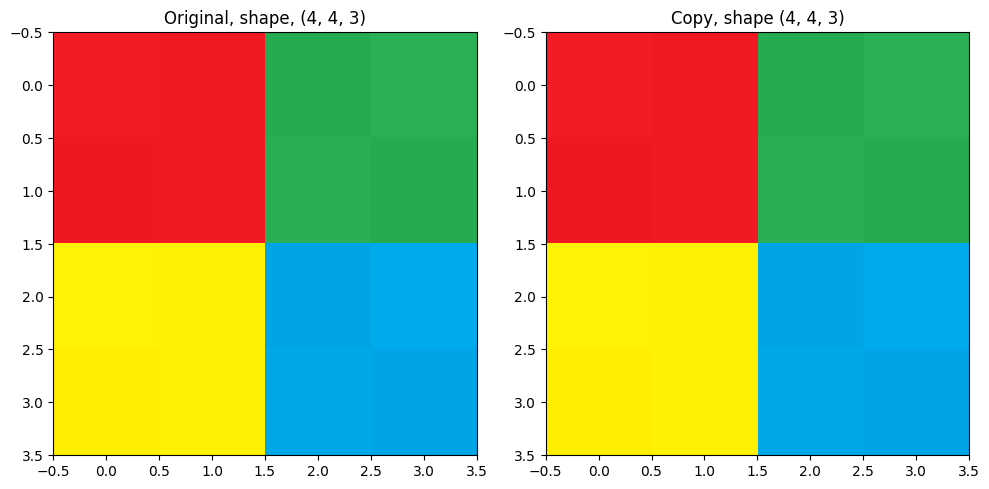

In [297]:
# img_path = '/content/PCD/PCD_Assignment01/grid.jpg'
# img_path = '/content/PCD/PCD_Assignment01/grid01.jpg'
# img_path = '/content/PCD/PCD_Assignment01/grid02.jpg'
# img_path = '/content/PCD/PCD_Assignment01/2x2.jpg'
# img_path = '/content/PCD/PCD_Assignment01/4x4.jpg'
img_path = '/content/PCD/PCD_Assignment01/4x4color.jpg'
# img_path = '/content/PCD/PCD_Assignment01/8x8color.jpg'
# img_path = '/content/PCD/PCD_Assignment01/8x8white.jpg'
# img_path = '/content/PCD/PCD_Assignment01/16x16.jpg'
# img_path = '/content/PCD/PCD_Assignment01/64x64.jpg'
# img_path = '/content/PCD/PCD_Assignment01/128x128.jpg'
# img_path = '/content/PCD/PCD_Assignment01/color01.jpg'
# img_path = '/content/PCD/PCD_Assignment01/color02.jpg'
# img_path = '/content/PCD/PCD_Assignment01/clouds.jpg'
# img_path = '/content/PCD/PCD_Assignment01/mountain.jpg'
# img_path = '/content/thunder16x16.jpg'

img,img_copy = Acquire(img_path,10)
# print(img[0][0],img_copy[-1][-1])

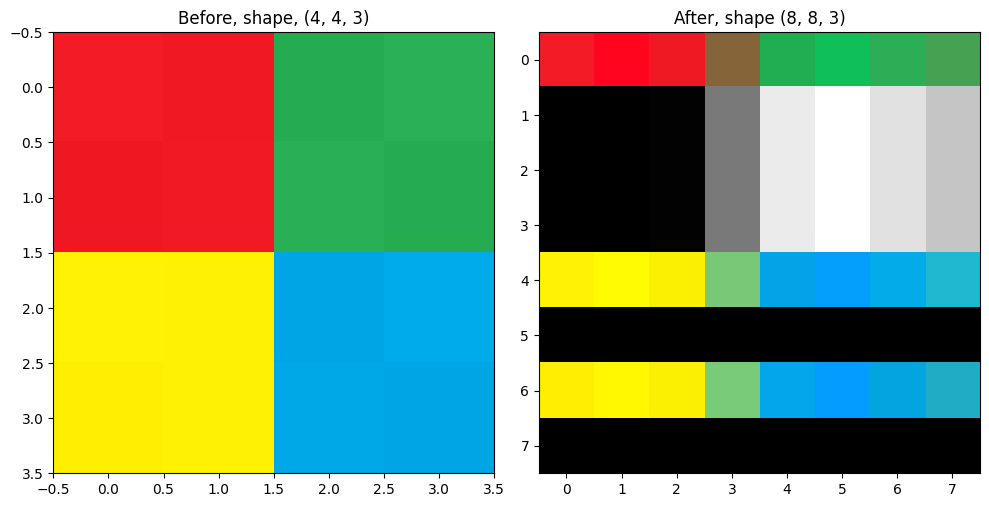

In [302]:
# DownSample(img_copy,order,size)
# Decimate(mode,img_copy,order,baris_baru,kolom_baru,size)
# up_Bilinear(img_copy,baris_baru,kolom_baru,size)
# up_NN(img_copy,baris_baru,kolom_baru,size)
# up_Bicubic(img_copy,baris_baru,kolom_baru,size)

# img_ds = DownSample(img_copy,1,8)

# img_dc = Decimate('MEAN',img_copy,2,2,10)

# img_us = up_NN(img_copy,600,600,10)

# img_us = up_Bilinear(img_copy,700,700,10)

img_us = up_Bicubic(img_copy,8,8,10)

##junk==================================================================================================================

In [ ]:
def up_Bicubic(img_copy,baris_baru,kolom_baru,size):

  img_copy = img_copy.astype(int)

  baris_lama, kolom_lama, c = img_copy.shape
  print(baris_lama,kolom_lama,c)

  img_us = np.zeros(shape=(baris_baru,kolom_baru,c))

  k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
  k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

  for i in range(baris_baru):
    for j in range(kolom_baru):

      #pemetaan koordinat baru ke lama (koordinat lama = koordinat baru * skala)
      x = i*k_baris
      y = j*k_kolom

      #4-Neighborhood dari (x,y)
      x1 = math.floor(x)
      x2 = min(baris_lama - 1, math.ceil(x))
      y1 = math.floor(y)
      y2 = min(kolom_lama - 1, math.ceil(y))

      if (x2 == x1) and (y2 == y1):
        q = img_copy[int(x), int(y), :]
      elif (x2 == x1):
        q1 = img_copy[int(x), int(y1), :]
        q2 = img_copy[int(x), int(y2), :]
        q = q1 * (y2 - y) + q2 * (y - y1)
      elif (y2 == y1):
        q1 = img_copy[int(x1), int(y), :]
        q2 = img_copy[int(x2), int(y), :]
        q = (q1 * (x2 - x)) + (q2	 * (x - x1))
      else:
        v1 = img_copy[x1, y1, :]
        v2 = img_copy[x2, y1, :]
        v3 = img_copy[x1, y2, :]
        v4 = img_copy[x2, y2, :]

        q1 = v1 * (x2 - x) + v2 * (x - x1)
        q2 = v3 * (x2 - x) + v4 * (x - x1)
        q = q1 * (y2 - y) + q2 * (y - y1)

      img_us[i,j,:] = q

  img_us = img_us.astype(np.uint8)
  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  # fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

In [ ]:
img_copy = img_copy.astype(int)
baris_lama, kolom_lama, c = img_copy.shape
# print(img_copy)

baris_baru = 8
kolom_baru = 8

img_us = np.zeros(shape=(baris_baru,kolom_baru,c))
# print(img_us)

k_baris = (baris_lama)/(baris_baru) if baris_baru != 0 else 0
k_kolom = (kolom_lama)/(kolom_baru) if kolom_baru != 0 else 0

RGB = []

for i in range(c):
  RGB.append(img_copy[:,:,i])

# r = img_copy[:,:,0]
# g = img_copy[:,:,1]
# b = img_copy[:,:,2]
# print(r)
# print(r[0,:])
# print(r[:,0])
# print(g)
# print(b)

# RGB = np.array([r,g,b])
# print(RGB[0,0,:])

xs = np.arange(0,len(r))
print(xs)

cs = CubicSpline(xs, RGB[0][0],bc_type='natural')#kolom wise

# cs = CubicSpline(xs, RGB[0,0,:])
# print(cs)

# new_xs = np.linspace(0,len(r)-1,(len(r)-1)*10)
new_xs = np.linspace(0,len(r),(len(r))*10*2)
new_cs = cs(new_xs)
new_cs = new_cs.astype(int)
print(new_cs)
# print(new_cs.shape)
print(len(new_cs))
# print(new_cs[0].type)

# for i in range(c):
cs1 = new_cs.copy()
# print(cs1)

for i in range(len(cs1)):
  if cs1[i] > 255:
    new_cs[i] = new_cs[i-1]
  elif cs1[i] < 0:
    new_cs[i] = new_cs[i-1]

print(new_cs)

f = np.arange(0,4,0.5)
# f = np.linspace(0,4,4*2)
# print(f)

plt.plot(f,np.ones(len(f)),'o')
# plt.plot(f,np.linspace(0,1,10),'o')
plt.plot(xs, RGB[0][0], 'o', label='data points')
plt.plot(new_xs, new_cs, label='cubic spline interpolation')
plt.show()

In [ ]:
print(img_copy)
# print(img_copy[:,:,0])

ys = img_copy[:,:,0].reshape(16) #nilai RGB
print(ys)
xs = np.arange(0,16) #koordinat
print(xs)

cs = CubicSpline(xs, ys)
# cs = CubicSpline(xs, ys,bc_type='natural')

new_xs = np.linspace(0,16,48)
new_cs = cs(new_xs)

print(new_cs)

plt.plot(xs, ys, 'o', label='data points')
plt.plot(new_xs, new_cs, label='cubic spline interpolation')
plt.show()


In [ ]:
#scipy

# xs = np.linspace(0, 2 * np.pi, num=10)
xs = np.linspace(0,10,10)
# xs = np.arange(0,10)
ys = np.sin(xs)
cs = CubicSpline(xs, ys)

new_xs = np.linspace(0,10,100)
# new_xs = np.arange(0,10,0.1)
new_cs = cs(new_xs)

# print(newarr)
# print(interp_func(xs))
# plt.plot(interp_func(xs))

plt.plot(xs, ys, 'o', label='data points')
plt.plot(new_xs, np.sin(new_xs), label='true sine wave')
plt.plot(new_xs, new_cs, label='cubic spline interpolation')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Spline Interpolation of Sine Wave')
plt.grid(True)
plt.show()

In [ ]:
baris_lama = 5
kolom_lama = 4

baris_baru = 2
kolom_baru = 2
k_baris = (baris_lama - 1)/(baris_baru)
k_kolom = (kolom_lama - 1)/(kolom_baru)

for i in range(baris_baru):
    for j in range(kolom_baru):
      # print(f"i={i}, j={j}")
      # print("==============")
      x1 = math.ceil(i*k_baris)
      x2 = math.floor((i+1)*k_baris)
      y1 = math.ceil(j*k_kolom)
      y2 = math.floor((j+1)*k_kolom)

      print(f"baris: {x1}-{x2}  kolom: {y1}-{y2}")

baris: 0-2  kolom: 0-1
baris: 0-2  kolom: 2-3
baris: 2-4  kolom: 0-1
baris: 2-4  kolom: 2-3


In [ ]:
def Upsample(img_copy,order,mode,size):
  #baris
  baris = img_copy.shape[0]*order
  # print(f"baris = {baris}")

  #kolom
  kolom = img_copy.shape[1]*order
  # print(f"kolom = {kolom}")

  #Matriks Image Upsample (img_us)
  # img_us = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
  img_us = np.zeros(shape=(baris,kolom,3),dtype=int)
  img_copy = img_copy.astype(int)
  print(img_copy.shape,"==>",img_us.shape)
  # print(img_us)

  for i in range(0,img_copy.shape[0]):
    for j in range(0,img_copy.shape[1]):
      img_us[i*order][j*order] = img_copy[i][j]

  #Upsampling
  match mode:

    case 0:#Nearest Neighbor (NN)
      mode = "Nearest Neighbor (NN)"
      for h in range(0,img_copy.shape[0]):
        for i in range(0,img_copy.shape[1]):
          for j in range(h*order,(h+1)*order):
            for k in range(i*order,(i+1)*order):
              img_us[j][k] = img_copy[h][i]
              # img_us[j][k][0] = min(img_us[h][i][0],img_copy[j][k][0])
              # img_us[j][k][1] = min(img_us[h][i][1],img_copy[j][k][1])
              # img_us[j][k][2] = min(img_us[h][i][2],img_copy[j][k][2])

    case 1:#Bilinear
      mode = "Bilinear"
      temp = [[],[],[]]

      for h in range(0,img_dc.shape[0]):
        for i in range(0,img_dc.shape[1]):
          for j in range(h*div,(h+1)*div):
            for k in range(i*div,(i+1)*div):
              temp[0].append(img_copy[j][k][0])
              temp[1].append(img_copy[j][k][1])
              temp[2].append(img_copy[j][k][2])
          img_dc[h][i][0] = st.median(temp[0])
          img_dc[h][i][1] = st.median(temp[1])
          img_dc[h][i][2] = st.median(temp[2])
          temp = [[],[],[]]
      img_dc = img_dc.astype(np.uint8)

    case 2:#Bicubic
      mode = "Bicubic"
      for h in range(0,img_dc.shape[0]):
        for i in range(0,img_dc.shape[1]):
          for j in range(h*div,(h+1)*div):
            for k in range(i*div,(i+1)*div):
              img_dc[h][i] += img_copy[j][k]
              # print(f"B[{h}][{i}]<==A[{j}][{k}]")
              # print("A:",img_copy[j][k])
              # print("B:\n",img_dc)
          img_dc[h][i] = np.round(img_dc[h][i]/(div*div))
      # print(img_dc)
      img_dc = img_dc.astype(np.uint8)

  fig, axs = plt.subplots(1, 2, figsize=(size, size))
  axs[0].imshow(img_copy)
  axs[0].set_title(f"Before, shape, {img_copy.shape}")
  axs[1].imshow(img_us)
  axs[1].set_title(f"After, shape {img_us.shape}")

  fig.suptitle(f"Upsample({mode})", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=1.45)
  plt.show()

  return img_us

#Upsample(img_copy,order,mode,size)
# A = Upsample(img_copy,10,0,14)

In [ ]:
# img2 = mpimg.imread(img02_path)
# plt.imshow(img2)
# plt.axis('off')
# plt.show()

In [ ]:
A = np.random.randint(0, 10, size=(8, 8))
print(A)

B = np.zeros(shape=(2,2))
print(B)

div = 2**2

for h in range(0,B.shape[0]):
  for i in range(0,B.shape[1]):
    for j in range(h*div,(h+1)*div):
      for k in range(i*div,(i+1)*div):
        print(f"B[{h}][{i}]<==A[{j}][{k}]")
        print("A:",A[j][k])
        B[h][i] += A[j][k]
        print("B:\n",B)
    B[h][i] = round((B[h][i])/div)

print(type(B[0][0]))


In [ ]:
# print(img02_copy[-1][-1])
print(MDS)
print("===============================")
M = np.array([1,2,3])
print(M.shape)
print(M)
M = M.reshape(1,3)
print(M.shape)
print(M)
print("===============================")
print(MDS[0].shape)
# MDS = np.append(M_DS,M)
MDS[0] = np.concatenate((MDS[0],M),axis=1)
# C = np.concatenate((M,MDS[0][0]),axis=0)
print(MDS[0][0].shape)
print(MDS)


In [ ]:
# pd.Series(img01.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

flat = img02.flatten()
# print(flat.shape)
# print(flat)

A = []

for i in range(len(flat)):
  if i%3==0:
    A.append(int(flat[i]))

A = np.array(A)
print(A[0].dtype)

# pd.Series(img02.flatten()).plot(kind="hist",
#                                bins=25,
#                                title='Pixel Values')
# plt.show()

int64


In [ ]:
A = np.zeros( (2, 3, 5) )
print("A = {}\n".format(A))
## 1rst term => depth
## 2 other terms => (i,j)

## basic 2D array
B = np.ones( (1,3, 5) )
print("B = {}\n".format(B))

## 2D array reshaped into 3D one prior to be concatenated
# Bprime = B.reshape(1,3,5)
# print("Bprime = {}\n".format(Bprime))

## C is created and suppoed to be A expanded by B
# C = np.concatenate( (A, Bprime) )
C = np.concatenate( (A, B), axis = 0)
print("C = {}\n".format(C))

In [ ]:
# length = len(flat)/3
# length = int(length)

# empty02 = np.zeros(shape=(length),dtype=np.uint8)
# print(empty02)

###oldDecimation

In [ ]:
# def Decimate(img_copy,order,mode,size):
#   div = 2**order

#   #baris
#   baris = img_copy.shape[0]//div
#   print(f"baris = {baris}, sisa baris = {img_copy.shape[0]%div}")

#   #kolom
#   kolom = img_copy.shape[1]//div
#   print(f"kolom = {kolom}, sisa kolom = {img_copy.shape[1]%div}")

#   #Matriks Image Decimation (img_dc)
#   # img_dc = np.zeros(shape=(baris,kolom,3),dtype=np.uint8)
#   img_dc = np.zeros(shape=(baris,kolom,3),dtype=int)
#   print(img_copy.shape,"==>",img_dc.shape)
#   # print(img_dc)

#   #Decimation
#   match mode:

#     case 0:#Max
#       mode = "Max"
#       for h in range(0,img_dc.shape[0]):
#         for i in range(0,img_dc.shape[1]):
#           for j in range(h*div,(h+1)*div):
#             for k in range(i*div,(i+1)*div):
#               img_dc[h][i][0] = max(img_dc[h][i][0],img_copy[j][k][0])
#               img_dc[h][i][1] = max(img_dc[h][i][1],img_copy[j][k][1])
#               img_dc[h][i][2] = max(img_dc[h][i][2],img_copy[j][k][2])

#     case 1:#Median
#       mode = "Median"
#       temp = [[],[],[]]
#       img_copy = img_copy.astype(int)
#       for h in range(0,img_dc.shape[0]):
#         for i in range(0,img_dc.shape[1]):
#           for j in range(h*div,(h+1)*div):
#             for k in range(i*div,(i+1)*div):
#               temp[0].append(img_copy[j][k][0])
#               temp[1].append(img_copy[j][k][1])
#               temp[2].append(img_copy[j][k][2])
#           img_dc[h][i][0] = st.median(temp[0])
#           img_dc[h][i][1] = st.median(temp[1])
#           img_dc[h][i][2] = st.median(temp[2])
#           temp = [[],[],[]]
#       img_dc = img_dc.astype(np.uint8)

#     case 2:#Mean
#       mode = "Mean"
#       for h in range(0,img_dc.shape[0]):
#         for i in range(0,img_dc.shape[1]):
#           for j in range(h*div,(h+1)*div):
#             for k in range(i*div,(i+1)*div):
#               img_dc[h][i] += img_copy[j][k]
#               # print(f"B[{h}][{i}]<==A[{j}][{k}]")
#               # print("A:",img_copy[j][k])
#               # print("B:\n",img_dc)
#           img_dc[h][i] = np.round(img_dc[h][i]/(div*div))
#       # print(img_dc)
#       img_dc = img_dc.astype(np.uint8)



#   fig, axs = plt.subplots(1, 2, figsize=(size, size))
#   axs[0].imshow(img_copy)
#   axs[0].set_title(f"Before, shape, {img_copy.shape}")
#   axs[1].imshow(img_dc)
#   axs[1].set_title(f"After, shape {img_dc.shape}")

#   fig.suptitle(f"Decimation({mode})", fontsize=16)
#   plt.tight_layout()
#   plt.subplots_adjust(top=1.45)
#   plt.show()

#   return img_dc
